In [ ]:
#git clone https://github.com/flixpar/AlphaTSP; credit to the original author

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

import torch_geometric
from torch_geometric.nn import GCNConv, global_mean_pool #graph convolutional network
from torch_geometric.data import Data, DataLoader

from ortools.constraint_solver import routing_enums_pb2 #google or tsp routing problem pkg
from ortools.constraint_solver import pywrapcp
from tqdm import tqdm

import numpy as np
import random
import copy
import math
import queue

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# TSP problem

class TSP():
    
    def __init__(self, n, side_length, d=2, points="random_euclidean"): #euclidean space
        self.n, self.d, self.side_length = n, d, side_length
        if isinstance(points, (list, np.ndarray)):
            self.points = points
        elif points == "random_euclidean":
            self.points = self.random_euclidean_tsp()
        else:
            raise ValueError("Invalid points argument to TSP.")

    def tour_length(self, tour):
        """Compute the length of the given tour.
        Arguments:
            tour {list(int, n)} -- a permutation of the nodes representing a tour
        Returns:
            float -- tour length
        """
        points = self.points[tour]
        diffs = np.diff(points, axis=0)
        tour_len = np.linalg.norm(diffs, axis=1, ord=2).sum()
        return tour_len

    def payoff(self, tour):
        """Compute the payoff of the given tour, a mapping of the tour length to
        [0,1] where 1 is a better tour.
        Arguments:
            tour {list(int, n)} -- a permutation of the nodes representing a tour
        Returns:
            float -- tour length
        """
        return ((2 * self.n) - self.tour_length(tour)) / (2 * self.n)

    def random_euclidean_tsp(self):
        points = np.random.randint(self.side_length, size=self.n*self.d).reshape(self.n, self.d)
#         points = self.side_length*np.random.rand(self.n, self.d)
        return points

In [3]:
# functions of Google OR-Tools, for optimal solution

def create_data_model(tsp):
    """Stores the data for the problem."""
    num_of_node = tsp.n
    
    data = {}
    data['distance_matrix'] = []
    
    for i in range(num_of_node):
        temp = [ tsp.tour_length([i,j]) for j in range(num_of_node) ]
        data['distance_matrix'].append(temp)

    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, d=2):
        super(PolicyNetwork, self).__init__()
        self.conv1 = GCNConv(d,  16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 1)
        self.fc    = nn.Linear(16, 1)
    
    def forward(self, graph): #network arcitecture
        x, edges, choices = graph.pos, graph.edge_index, graph.y
        
        x = self.conv1(x, edges)
        x = F.relu(x)
        x = self.conv2(x, edges)
        x = F.relu(x)
        
        c = self.conv3(x, edges)
        choice = torch.masked_select(c.squeeze(), choices)
        choice = F.softmax(choice, dim=0)
        
        v = global_mean_pool(x, torch.zeros(graph.num_nodes, dtype=torch.long))
        value = self.fc(v)

        return choice, value

In [5]:
class MCTSNode(): #define the node for MCTS algorithm

    def __init__(self, p=None, t=[0], r=None, tsp=None):
        self.parent = p
        self.tsp = tsp
        self.tour = t
        self.remaining = r if r is not None else list(range(1, tsp.n))
        self.visits = 0
        self.total_score = 0
        self.avg_score = 1 / (len(self.remaining)+1)
        self.c = 0.7
        self.n = tsp.n
        self.children = []
        self.graph = None
        self.action = self.tour[-1]

    def expand(self):
        k = random.choice(self.remaining)
        t = copy.copy(self.tour)
        r = copy.copy(self.remaining)
        t.append(k)
        r.remove(k)
        child = MCTSNode(self, t, r, self.tsp)
        self.children.append(child)
        return child
    
    def add_child(self, k):
        for child in self.children:
            if child.action == k:
                return child
        t = copy.copy(self.tour)
        r = copy.copy(self.remaining)
        t.append(k)
        r.remove(k)
        child = MCTSNode(self, t, r, self.tsp)
        self.children.append(child)
        return child

    def backprop(self, reward):
        self.visits += 1
        self.total_score += reward
        self.avg_score = self.total_score / self.visits
        if self.parent is not None:
            self.parent.backprop(reward)

    def simulate(self):
        random.shuffle(self.remaining)
        t = self.tour + self.remaining + [0]
        return self.tsp.payoff(t)

    def has_children(self):
        return len(self.children) != 0

    def is_leaf(self):
        return len(self.tour) == self.n
    
    def is_fully_expanded(self):
        return len(self.remaining) == len(self.children)

    def get_tour(self):
        return self.tour + [self.tour[0]]

    def best_child_score(self):
        return max(self.children, key = lambda child: child.avg_score)

    def best_child_uct(self):
        k = math.log(self.visits)
        return max(self.children, key = lambda child: child.avg_score + self.c * math.sqrt(2 * k / child.visits))

    def best_child_visits(self):
        return max(self.children, key = lambda child: child.visits)
    
    def best_child_policy(self, model):
        if len(self.children) == 0: raise Exception("No children to select from.")
        if len(self.children) == 1: return self.children[0]
        
        model.eval()
        
        actions = [child.action for child in self.children]
        r = list(set.intersection(set(actions), set(self.remaining)))
        z = np.zeros(self.n, dtype=np.int)
        z[r] = 1
        z = z[self.remaining]
        
        graph = self.construct_graph()
        pred, value = model(graph)
         
        pred = pred.squeeze()[z]
        selection = torch.argmax(pred)
        
        return self.children[selection]
    
    def select_child_policy(self, model):
        if len(self.children) == 0: raise Exception("No children to select from.")
        if len(self.children) == 1: return self.children[0]
        
        model.eval()

        actions = [child.action for child in self.children]
        r = list(set.intersection(set(actions), set(self.remaining)))
        z = np.zeros(self.n, dtype=np.int)
        z[r] = 1
        z = z[self.remaining]
        
        graph = self.construct_graph()
        pred, value = model(graph)
         
        pred = pred.squeeze()[z]
        selection = torch.multinomial(pred, 1)
        return self.children[selection]
    
    def best_remaining_policy(self, model):
        if len(self.remaining) == 0: raise Exception("No remaining to select from.")
        if len(self.remaining) == 1: return self.add_child(self.remaining[0])
        
        model.eval()
        
        graph = self.construct_graph()
        pred, value = model(graph)
        
        selection = torch.argmax(pred.squeeze()).item()
        selection = self.remaining[selection]
        
        return self.add_child(selection)
    
    def select_remaining_policy(self, model):
        if len(self.remaining) == 0: raise Exception("No remaining to select from.")
        if len(self.remaining) == 1: return self.add_child(self.remaining[0])
        
        model.eval()
        
        graph = self.construct_graph()
        pred, value = model(graph)
        
        selection = torch.argmax(pred.squeeze()).item()
        selection = self.remaining[selection]
        
        selection = torch.multinomial(pred.squeeze(), 1)
        return self.add_child(selection)
    
    def construct_graph(self):
        if self.graph is not None:
            return self.graph

        points = torch.tensor(self.tsp.points).to(dtype=torch.float)

        edges = torch.zeros((2, len(self.tour)-1), dtype=torch.long)
        for i in range(len(self.tour)-1):
            edges[0, i] = self.tour[i]
            edges[1, i] = self.tour[i+1]

        choices = torch.zeros(self.n, dtype=torch.uint8)
        choices[self.remaining] = 1
        
        x = torch.cat([points, choices.unsqueeze(-1).to(dtype=torch.float)], dim=-1)

        self.graph = Data(x=x, pos=points, edge_index=edges, y=choices)
        
        return self.graph

In [6]:
class MCTSSolver(): #define the class for Monte Calro Tree Search
    
    def __init__(self, tsp, iterations=1000):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.iterations = iterations
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.best_child_uct()
        return node

In [7]:
class PolicySolver(): #Pure Policy-based reinforcement learning solver
    
    def __init__(self, tsp, model):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.model = model
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = node.best_remaining_policy(model=self.model)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

In [8]:
class PolicyMCTSSolver(): #Using GNN representation to speed up the MCTS
    
    def __init__(self, tsp, model, iterations=50):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.iterations = iterations
        self.model = model
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.select_child_policy(self.model)
        return node

In [9]:
class MCTSExampleGenerator(): #generate samples for MCTS model
    
    def __init__(self, tsp, example_queue, iterations=1000):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.example_queue = example_queue
        self.iterations = iterations
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
            self.generate_example(node.parent)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.best_child_uct()
        return node
    
    def generate_example(self, node):
        
        # construct graph
        graph = node.construct_graph()
        
        # construct labels
        
        choice_probs = [(child.tour[-1], child.visits) for child in node.children]
        choice_probs = sorted(choice_probs, key = lambda c: c[1])
        choice_probs = [c[0] for c in choice_probs]
        choice_probs = torch.tensor(choice_probs).to(dtype=torch.float)
        choice_probs = choice_probs / choice_probs.sum()
        
        choice = torch.argmax(choice_probs)
        
        pred_value = torch.tensor(node.avg_score)
        
        # add to training queue
        example = {
            "graph": graph,
            "choice_probs": choice_probs,
            "choice": choice,
            "pred_value": pred_value,
        }
        self.example_queue.put(example)

In [10]:
class MCTSPolicyExampleGenerator(): #generate samples for the GNN model with MCTS
    
    def __init__(self, tsp, example_queue, model, iterations=500):
        self.tsp = tsp
        self.root_node = MCTSNode(tsp=self.tsp)
        self.example_queue = example_queue
        self.model = model
        self.iterations = iterations
    
    def solve(self):
        node = self.root_node
        while not node.is_leaf():
            node = self.mcts_search(node)
            self.generate_example(node.parent)
        mcts_tour = node.get_tour()
        mcts_payoff = self.tsp.tour_length(mcts_tour)
        return mcts_tour, mcts_payoff

    def mcts_search(self, start_node):
        for _ in range(self.iterations):
            node = self.tree_policy(start_node)
            pay = node.simulate()
            node.backprop(pay)
        return start_node.best_child_score()

    def tree_policy(self, start_node):
        node = start_node
        while not node.is_leaf():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.select_child_policy(self.model)
        return node
    
    def generate_example(self, node):
        
        # construct graph
        graph = node.construct_graph()
        
        # construct labels
        
        choice_probs = [(child.tour[-1], child.visits) for child in node.children]
        choice_probs = sorted(choice_probs, key = lambda c: c[1])
        choice_probs = [c[0] for c in choice_probs]
        choice_probs = torch.tensor(choice_probs).to(dtype=torch.float)
        choice_probs = choice_probs / choice_probs.sum()
        
        choice = torch.argmax(choice_probs)
        
        pred_value = torch.tensor(node.avg_score)
        
        # add to training queue
        example = {
            "graph": graph,
            "choice_probs": choice_probs,
            "choice": choice,
            "pred_value": pred_value,
        }
        self.example_queue.put(example)

In [11]:
class PolicyNetworkTrainer(): #the class for training policy-based network
    
    def __init__(self, model, example_queue):
        self.model = model
        self.example_queue = example_queue
        self.losses = []
        
    def train_example(self):
        self.model.train()
        
        example = self.example_queue.get()
        graph, choice_probs, value = example["graph"], example["choice_probs"], example["pred_value"]
        
        pred_choices, pred_value = self.model(graph)
        loss = loss_fn(pred_choices, choice_probs) + (0.2 * loss_fn(pred_value, value))
        
        self.losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    def train_all(self):
        self.model.train()
        while not self.example_queue.empty():

            example = self.example_queue.get()
            graph, choice_probs, value = example["graph"], example["choice_probs"], example["pred_value"]
            
            pred_choices, pred_value = self.model(graph)
            loss = loss_fn(pred_choices, choice_probs) + (0.2 * loss_fn(pred_value, value))
            
            self.losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [14]:
num_nodes_train = 10
num_nodes_test = [5, 10, 20]
side_length = 100

num_test_samples = 40
list_num_train_samples = np.array([2, 8, 32, 128, 256, 512])


PolicyMCTS_prop = [[] for _ in range(len(num_nodes_test))]

for num_train_samples in list_num_train_samples:
    # before train PolicyMCTS
    train_queue = queue.Queue()
    policy_network = PolicyNetwork()
    optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=3e-4)
    loss_fn = nn.MSELoss()

    # generate training examples
    for _ in tqdm(range(num_train_samples)):
        tsp = TSP(num_nodes_train, side_length, d=2)
        solver = MCTSExampleGenerator(tsp, train_queue)
        solver.solve()

    # train PolicyMCTS
    trainer = PolicyNetworkTrainer(policy_network, train_queue)
    trainer.train_all()
    policy_network = trainer.model #policy_network is the gnn model based on policy
    
    
    # test
    for i, num_node_test in enumerate(num_nodes_test):
        PolicyMCTS_cost = []
        optimal_cost = []
        for _ in tqdm(range(num_test_samples)):
            
            tsp = TSP(num_node_test, side_length, d=2)

            ### policy network mcts
            solver = PolicyMCTSSolver(tsp, policy_network)
            PolicyMCTS_cost.append(solver.solve()[1])


            ### optimal solution by Google OR-Tools
            data = create_data_model(tsp)
            # Create the routing index manager.
            manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

            # Create Routing Model.
            routing = pywrapcp.RoutingModel(manager)
            transit_callback_index = routing.RegisterTransitCallback(distance_callback)

            # Define cost of each arc.
            routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

            # Setting first solution heuristic.
            search_parameters = pywrapcp.DefaultRoutingSearchParameters()
            search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

            # Solve the problem.
            solution = routing.SolveWithParameters(search_parameters)
            optimal_cost.append(solution.ObjectiveValue())
        
        # Transform the list to array
        PolicyMCTS_cost = np.array(PolicyMCTS_cost)
        optimal_cost = np.array(optimal_cost)
            
        print(num_train_samples, num_nodes_test[i])
        print(sum(PolicyMCTS_cost < 1.1*optimal_cost)/num_test_samples)
    
    PolicyMCTS_prop[i].append(sum(PolicyMCTS_cost < 1.1*optimal_cost)/num_test_samples)
    
   
    


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

100%|██████████| 40/40 [00:20<00:00,  2.00it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

2 5
0.8



100%|██████████| 40/40 [00:54<00:00,  1.37s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

2 10
0.025



100%|██████████| 40/40 [01:28<00:00,  2.21s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

2 20
0.0



100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

8 5
0.8



100%|██████████| 40/40 [00:54<00:00,  1.35s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

8 10
0.175



100%|██████████| 40/40 [01:31<00:00,  2.28s/it]

  0%|          | 0/32 [00:00<?, ?it/s]

8 20
0.0



100%|██████████| 32/32 [00:18<00:00,  1.71it/s]

100%|██████████| 40/40 [00:20<00:00,  1.92it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

32 5
0.75



100%|██████████| 40/40 [00:55<00:00,  1.38s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

32 10
0.025



100%|██████████| 40/40 [01:32<00:00,  2.30s/it]

  0%|          | 0/128 [00:00<?, ?it/s]

32 20
0.0



100%|██████████| 128/128 [01:14<00:00,  1.72it/s]

100%|██████████| 40/40 [00:19<00:00,  2.03it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

128 5
0.725



100%|██████████| 40/40 [00:48<00:00,  1.22s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

128 10
0.125



100%|██████████| 40/40 [01:25<00:00,  2.14s/it]

  0%|          | 0/256 [00:00<?, ?it/s]

128 20
0.0



100%|██████████| 256/256 [02:29<00:00,  1.71it/s]

100%|██████████| 40/40 [00:19<00:00,  2.02it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

256 5
0.775



100%|██████████| 40/40 [00:48<00:00,  1.20s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

256 10
0.125



100%|██████████| 40/40 [01:25<00:00,  2.13s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

256 20
0.0



100%|██████████| 512/512 [04:58<00:00,  1.72it/s]

100%|██████████| 40/40 [00:19<00:00,  2.04it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

512 5
0.775



100%|██████████| 40/40 [00:48<00:00,  1.21s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

512 10
0.1



100%|██████████| 40/40 [01:25<00:00,  2.13s/it]

512 20
0.0


In [17]:
num_nodes_train = 10
num_nodes_test = [5, 10, 20]
side_length = 100

num_test_samples = 10
list_num_train_samples = np.array([2, 32, 128, 256, 512])


PolicyMCTS_prop = [[] for _ in range(len(num_nodes_test))]

for num_train_samples in list_num_train_samples:
    # before train PolicyMCTS
    train_queue = queue.Queue()
    policy_network = PolicyNetwork()
    optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=3e-4)
    loss_fn = nn.MSELoss()

    # generate training examples
    for _ in tqdm(range(num_train_samples)):
        tsp = TSP(num_nodes_train, side_length, d=2)
        solver = MCTSExampleGenerator(tsp, train_queue)
        solver.solve()

    # train PolicyMCTS
    trainer = PolicyNetworkTrainer(policy_network, train_queue)
    trainer.train_all()
    policy_network = trainer.model #policy_network is the gnn model based on policy
    
    
    # test
    for i, num_node_test in enumerate(num_nodes_test):
        PolicyMCTS_cost = []
        optimal_cost = []
        for _ in tqdm(range(num_test_samples)):
            
            tsp = TSP(num_node_test, side_length, d=2)

            ### policy network mcts
            solver = PolicyMCTSSolver(tsp, policy_network)
            PolicyMCTS_cost.append(solver.solve()[1])


            ### optimal solution by Google OR-Tools
            data = create_data_model(tsp)
            # Create the routing index manager.
            manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

            # Create Routing Model.
            routing = pywrapcp.RoutingModel(manager)
            transit_callback_index = routing.RegisterTransitCallback(distance_callback)

            # Define cost of each arc.
            routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

            # Setting first solution heuristic.
            search_parameters = pywrapcp.DefaultRoutingSearchParameters()
            search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

            # Solve the problem.
            solution = routing.SolveWithParameters(search_parameters)
            optimal_cost.append(solution.ObjectiveValue())
        
        # Transform the list to array
        PolicyMCTS_cost = np.array(PolicyMCTS_cost)
        optimal_cost = np.array(optimal_cost)
            
        print(num_train_samples, num_nodes_test[i])
        print(sum(PolicyMCTS_cost < 1.1*optimal_cost)/num_test_samples)
    
        PolicyMCTS_prop[i].append(sum(PolicyMCTS_cost < 1.1*optimal_cost)/num_test_samples)
    


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2 5
0.7



100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

2 10
0.0



100%|██████████| 10/10 [00:23<00:00,  2.33s/it]

  0%|          | 0/32 [00:00<?, ?it/s]

2 20
0.0



100%|██████████| 32/32 [00:18<00:00,  1.71it/s]

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

32 5
0.9



100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

32 10
0.1



100%|██████████| 10/10 [00:22<00:00,  2.29s/it]

  0%|          | 0/128 [00:00<?, ?it/s]

32 20
0.0



100%|██████████| 128/128 [01:14<00:00,  1.72it/s]

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

128 5
0.9



100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

128 10
0.0



100%|██████████| 10/10 [00:22<00:00,  2.30s/it]

  0%|          | 0/256 [00:00<?, ?it/s]

128 20
0.0



100%|██████████| 256/256 [02:29<00:00,  1.72it/s]

100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

256 5
0.7



100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

256 10
0.2



100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

256 20
0.0



100%|██████████| 512/512 [04:58<00:00,  1.71it/s]

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

512 5
0.7



100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

512 10
0.2



100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

512 20
0.0


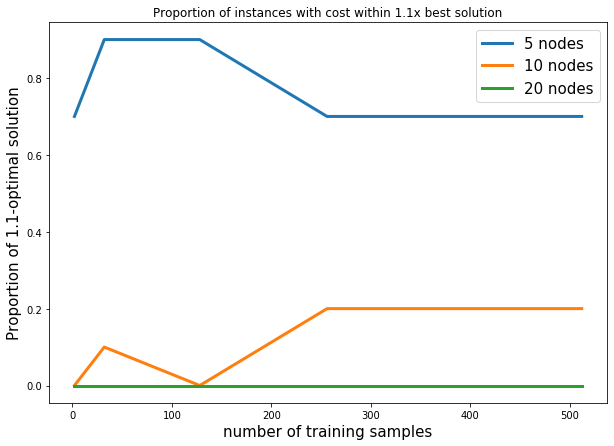

In [18]:
f = plt.figure(figsize = (10,7))
plt.plot(list_num_train_samples, PolicyMCTS_prop[0], linewidth=3, label='5 nodes')
plt.plot(list_num_train_samples, PolicyMCTS_prop[1], linewidth=3, label='10 nodes')
plt.plot(list_num_train_samples, PolicyMCTS_prop[2], linewidth=3, label='20 nodes')
plt.xlabel('number of training samples', size=15)
plt.ylabel('Proportion of 1.1-optimal solution', size=15)
plt.title("Proportion of instances with cost within 1.1x best solution")
plt.legend(loc='best', fontsize=15)
plt.show()